In [33]:
import numpy as np
import pandas as pd
import glob
import os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, MinMaxScaler


In [34]:
median_income_data_source = r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Rent Training Data\ACSDT5Y2022.B19013-Data.csv"

training_data_source = r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Redfin Data\rentals_0926.csv"

In [35]:
df = pd.read_csv(training_data_source)
property_type_counts = df.groupby("property_type").size().reset_index(name='count')

# Display the result
print(property_type_counts)

   property_type  count
0             13   1518
1              4   1622
2              5  23060
3              6  18997
4  property_type      9


In [36]:
(df[df["property_type"].isin(["6"])][["address", "property_type", "description"]]).head(30)

,address,property_type,description
0,3902 S 284th Pl Unit 390,6,You deserve a happy house that offers all the ...
1,3902 S 284th Pl Unit 1,6,You deserve a happy house that offers all the ...
2,3902 S 284th Pl Unit 21,6,You will love making this gorgeous house your ...
3,3243 S 291st St,6,"Check this home out, rambler four bedrooms 2.5..."
4,4341 S 299th St,6,This extraordinary split-level home sits on a ...
5,33708 42nd Ct S,6,Application fee is $20 per household for a lim...
6,3801 S 292nd Pl,6,Application fee is $20 per household for a lim...
8,30861 52nd Ave S,6,"Basement unit with 2 Bedrooms, 1.75 bathroom. ..."
9,4323 S 366th St,6,$500 off first full months base rent when you ...
11,29816 43rd Ave S,6,Four bedroom home for rent in Auburn. Home Fea...


In [37]:
df = pd.read_csv(training_data_source)

df = df.rename(columns={
    # 'Max Square Feet': 'square_feet',
    # 'Max Beds': 'bedrooms',
    # 'Max Baths': 'bathrooms',
    'price': 'rent',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
})

basic_metadata = ["property_id", "address", "city", "state"]
basic_features = ["square_feet", "bedrooms", "bathrooms"]
target = "rent"


for feature in basic_features + [target, "latitude", "longitude"]:
    df[feature] = pd.to_numeric(df[feature], errors='coerce')


df = df[(df["bedrooms"] > 0 ) 
        & (df["bedrooms"] < 6)  
        & (df["bathrooms"] < 4)  
        & (df["square_feet"] < 5000)  
        & (df["rent"] < 10000)  
        & (df["state_code"].notna()) 
        & (df["property_type"] == "6") 
    ]

df = df.drop_duplicates(subset=["latitude", "longitude"])

#Get Median Income Data
median_income = pd.read_csv(median_income_data_source, skiprows=[1], na_values='-')

median_income['GEO_ID'] = median_income['GEO_ID'].astype(str)

# Extracting everything after "US" and storing it in a new column 'cbg_geoid'
median_income['cbg_geoid'] = median_income['GEO_ID'].str.extract('US(\d+)')
median_income['median_income'] = median_income['B19013_001E'].str.replace(',','+').str.replace('+','').str.replace('-','').astype(float)

median_income = median_income[["cbg_geoid", "median_income" ]]

print(df["property_id"].count())

df["cbg_geoid"] = df["cbg_geoid"].astype(str).str.split('.').str[0]
median_income["cbg_geoid"] = median_income["cbg_geoid"].astype(str)

df = df.merge(median_income, on='cbg_geoid', how="inner")

print(df["property_id"].count())


11965
11965


In [38]:
columns_to_encode = ['bedrooms', 'bathrooms']

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid dummy variable trap

# Fit and transform the data
encoded_features = encoder.fit_transform(df[columns_to_encode])

# Get feature names for the encoded columns
encoded_feature_names = encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Concatenate the original DataFrame (excluding the original columns) with the encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)

one_hot_features = encoded_feature_names.tolist()

In [39]:
import joblib
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

# Assuming 'df' is your DataFrame and it's already loaded
# Example:
# df = pd.read_csv('your_data.csv')

knn_features = ["latitude", "longitude"]
target = 'rent'

# List of different n values
n_values = [1, 5, 10]  # You can adjust these as needed
max_n = max(n_values)

# Convert latitude and longitude from degrees to radians for haversine metric
df_rad = np.radians(df[knn_features].values)

# Drop rows with missing values in the knn_features or target columns
knn_df = df[knn_features + [target]].dropna()

# Extract feature values and target values
X = knn_df[knn_features].values
y = knn_df[target].values

# Convert latitude and longitude from degrees to radians for haversine metric
X_rad = np.radians(X)

# Initialize the KNeighborsRegressor with the haversine metric
# Set n_neighbors to max_n + 1 to account for excluding the point itself
knn = KNeighborsRegressor(n_neighbors=max_n *2, metric='haversine')

# Fit the KNN model
knn.fit(X_rad, y)

# Save the model if needed
# joblib.dump(knn, fr'C:\Users\mattl\OneDrive\Desktop\Projects\stoebebirch\Models\knn_model_{max_n}_neighbors.pkl')

# Find the neighbors for each point in the original DataFrame
distances, indices = knn.kneighbors(df_rad)

# Initialize dictionaries to hold rent benchmarks and average distances
rent_benchmarks = {n: [] for n in n_values}
average_distances = {n: [] for n in n_values}

# Iterate over each point's neighbors
for i in range(len(df)):
    # Extract distances and indices for the current point
    current_distances = distances[i]
    current_indices = indices[i]
    
    # Filter out neighbors with distance = 0 (self)
    valid_mask = current_distances > 0
    valid_distances = current_distances[valid_mask]
    valid_indices = current_indices[valid_mask]
    
    # If you have missing values in y_full, ensure alignment
    # Create a mapping from knn_df's indices to y
    # Since knn_df is a subset of df, we need to map original indices
    # Assuming df's index aligns with y_full
    # Otherwise, adjust accordingly
    neighbor_rents = y[knn_df.index.get_indexer(valid_indices)]
    
    for n in n_values:
        if len(neighbor_rents) >= n:
            selected_rents = neighbor_rents[:n]
            selected_distances = valid_distances[:n]
        else:
            # Handle cases where fewer than n neighbors are available
            selected_rents = neighbor_rents
            selected_distances = valid_distances
        # Compute average rent
        avg_rent = selected_rents.mean() if len(selected_rents) > 0 else np.nan
        rent_benchmarks[n].append(avg_rent)
        
        # Compute average distance in kilometers (haversine distance is in radians)
        # Earth's radius ≈ 6371 km
        avg_distance_km = selected_distances.mean() * 6371 if len(selected_distances) > 0 else np.nan
        average_distances[n].append(avg_distance_km)

# Add the computed benchmarks and distances to the DataFrame
for n in n_values:
    df[f'Rent_Benchmark_{n}_neighbors'] = rent_benchmarks[n]
    df[f'Average_Distance_{n}_neighbors'] = average_distances[n]

benchmark_features = [f'Rent_Benchmark_{n}_neighbors' for n in n_values]

# Display the selected columns
display(df[basic_metadata+  benchmark_features + [target]].head(20))


,property_id,address,city,state,Rent_Benchmark_1_neighbors,Rent_Benchmark_5_neighbors,Rent_Benchmark_10_neighbors,rent
0,192795905,3902 S 284th Pl Unit 390,Auburn,WA,3275.0,2373.0,2480.9,2000.0
1,212002,4341 S 299th St,Auburn,WA,3275.0,2274.0,2338.4,2995.0
2,8188776,33708 42nd Ct S,Federal Way,WA,2350.0,2452.0,2823.0,3295.0
3,211486,3801 S 292nd Pl,Auburn,WA,2000.0,2218.0,2310.4,3275.0
4,211201,30861 52nd Ave S,Auburn,WA,2995.0,2763.0,2422.5,2350.0
5,364718,4323 S 366th St,Auburn,WA,1550.0,3198.0,3292.5,3145.0
6,192745021,31706 5th Ave S Unit 6,Federal Way,WA,2250.0,2908.0,2885.0,1520.0
7,366496,1639 S 374th Ct,Federal Way,WA,3695.0,3637.0,3282.0,3350.0
8,205461,2014 S 308th St,Federal Way,WA,1520.0,2528.0,2468.0,2250.0
9,192136465,2613 S 272nd St,Federal Way,WA,1750.0,2653.8,2450.9,1495.0


In [40]:
bed_feature = 'bedrooms'

# Extract the bed feature values
bed_df = df[knn_features + [target, bed_feature]].dropna()

X_bed = bed_df[knn_features].values
y_bed = bed_df[target].values
beds = bed_df[bed_feature].values

# Convert latitude and longitude from degrees to radians for haversine metric
X_bed_rad = np.radians(X_bed)

# Fit the KNN model again using a larger neighbor count and filter by beds after
knn_beds = KNeighborsRegressor(n_neighbors=max_n * 2, metric='haversine')

# Fit the model
knn_beds.fit(X_bed_rad, y_bed)

# Find neighbors and distances
bed_distances, bed_indices = knn_beds.kneighbors(df_rad)

# Initialize dictionaries to hold rent benchmarks and distances filtered by beds
bed_rent_benchmarks = {n: [] for n in n_values}
bed_average_distances = {n: [] for n in n_values}

# Iterate over each point's neighbors and filter by number of beds
for i in range(len(df)):
    current_distances_bed = bed_distances[i]
    current_indices_bed = bed_indices[i]
    
    # Filter out neighbors with distance = 0 (self)
    valid_mask_bed = current_distances_bed > 0
    valid_distances_bed = current_distances_bed[valid_mask_bed]
    valid_indices_bed = current_indices_bed[valid_mask_bed]
    
    # Get the number of beds for the current property
    current_beds = df.loc[i, bed_feature]
    
    # Filter neighbors that have the same number of beds
    valid_beds_mask = beds[valid_indices_bed] == current_beds
    valid_distances_bed = valid_distances_bed[valid_beds_mask]
    valid_indices_bed = valid_indices_bed[valid_beds_mask]
    
    # Get the rent of the valid neighbors with the same number of beds
    neighbor_rents_bed = y_bed[valid_indices_bed]
    
    for n in n_values:
        if len(neighbor_rents_bed) >= n:
            selected_rents_bed = neighbor_rents_bed[:n]
            selected_distances_bed = valid_distances_bed[:n]
        else:
            # Handle cases where fewer than n neighbors are available
            selected_rents_bed = neighbor_rents_bed
            selected_distances_bed = valid_distances_bed
        
        # Compute average rent
        avg_rent_bed = selected_rents_bed.mean() if len(selected_rents_bed) > 0 else np.nan
        bed_rent_benchmarks[n].append(avg_rent_bed)
        
        # Compute average distance for beds
        avg_distance_km_bed = selected_distances_bed.mean() * 6371 if len(selected_distances_bed) > 0 else np.nan
        bed_average_distances[n].append(avg_distance_km_bed)

# Add the computed rent and distance by beds to the DataFrame
for n in n_values:
    df[f'Beds_Rent_Benchmark_{n}_neighbors'] = bed_rent_benchmarks[n]
    df[f'Beds_Average_Distance_{n}_neighbors'] = bed_average_distances[n]

# Display the selected columns
benchmark_features = [f'Rent_Benchmark_{n}_neighbors' for n in n_values]
bed_benchmark_features = [f'Beds_Rent_Benchmark_{n}_neighbors' for n in n_values]

# Display the selected columns
display(df[basic_metadata + benchmark_features + bed_benchmark_features + [target]].head(20))

,property_id,address,city,state,Rent_Benchmark_1_neighbors,Rent_Benchmark_5_neighbors,Rent_Benchmark_10_neighbors,Beds_Rent_Benchmark_1_neighbors,Beds_Rent_Benchmark_5_neighbors,Beds_Rent_Benchmark_10_neighbors,rent
0,192795905,3902 S 284th Pl Unit 390,Auburn,WA,3275.0,2373.0,2480.9,3275.0,3161.8,3281.500000,2000.0
1,212002,4341 S 299th St,Auburn,WA,3275.0,2274.0,2338.4,3275.0,2962.8,2993.166667,2995.0
2,8188776,33708 42nd Ct S,Federal Way,WA,2350.0,2452.0,2823.0,3145.0,3292.0,3201.250000,3295.0
3,211486,3801 S 292nd Pl,Auburn,WA,2000.0,2218.0,2310.4,2000.0,2906.8,3069.000000,3275.0
4,211201,30861 52nd Ave S,Auburn,WA,2995.0,2763.0,2422.5,2250.0,2260.0,2260.000000,2350.0
5,364718,4323 S 366th St,Auburn,WA,1550.0,3198.0,3292.5,3350.0,3397.0,3354.285714,3145.0
6,192745021,31706 5th Ave S Unit 6,Federal Way,WA,2250.0,2908.0,2885.0,3500.0,3086.0,3130.000000,1520.0
7,366496,1639 S 374th Ct,Federal Way,WA,3695.0,3637.0,3282.0,3695.0,3457.0,3354.285714,3350.0
8,205461,2014 S 308th St,Federal Way,WA,1520.0,2528.0,2468.0,2500.0,2115.0,2115.000000,2250.0
9,192136465,2613 S 272nd St,Federal Way,WA,1750.0,2653.8,2450.9,1545.0,2048.0,2229.375000,1495.0


In [41]:
import pandas as pd

# Function to calculate group averages excluding the current row
def calculate_average_excluding_self(df, group_column, target_column):
    """
    This function calculates the average of `target_column` for each group in `group_column`,
    excluding the current row in the group to avoid data leakage.
    """
    group_sums = df.groupby(group_column)[target_column].transform('sum')
    group_counts = df.groupby(group_column)[target_column].transform('count')
    
    # Exclude the current row's rent from the sum and subtract 1 from the count
    df[f'{group_column}_average_rent'] = (group_sums - df[target_column]) / (group_counts - 1)
    
    return df

# Load your data (assuming df is already loaded)
# Example:
# df = pd.read_csv('single_family_home_rentals.csv')

# Calculate the average rent per CBSA excluding the current row
df = calculate_average_excluding_self(df, 'cbsa_geoid', 'rent')

# Calculate the average rent per State excluding the current row
df = calculate_average_excluding_self(df, 'state_code', 'rent')

df = calculate_average_excluding_self(df, 'state_code', 'rent')


# Display the first few rows to verify the results
display(df[['cbsa_geoid', 'state_code', 'rent', 'cbsa_geoid_average_rent', 'state_code_average_rent']].head())



,cbsa_geoid,state_code,rent,cbsa_geoid_average_rent,state_code_average_rent
0,42660,WA,2000.0,3282.005186,2900.226242
1,42660,WA,2995.0,3281.145203,2899.746261
2,42660,WA,3295.0,3280.885912,2899.601544
3,42660,WA,3275.0,3280.903198,2899.611192
4,42660,WA,2350.0,3281.702679,2900.057405


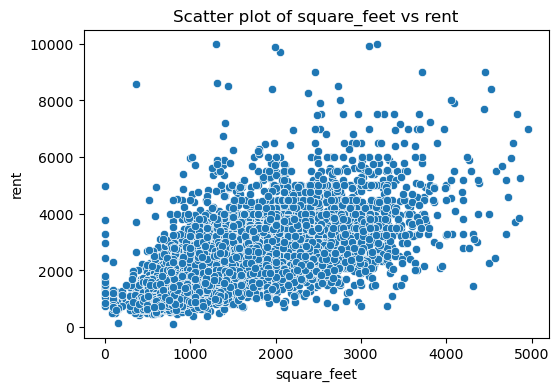

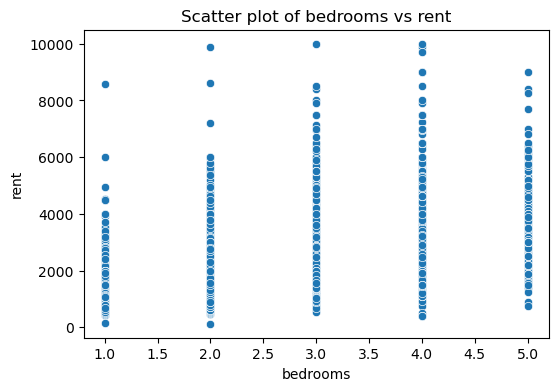

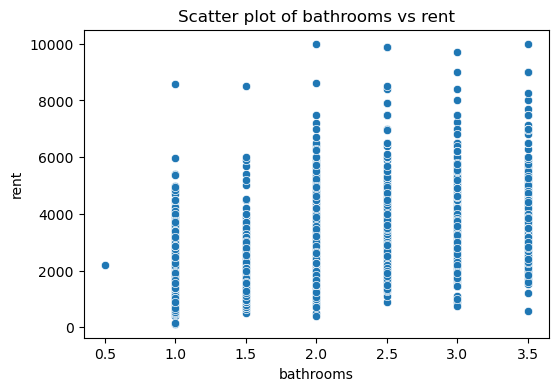

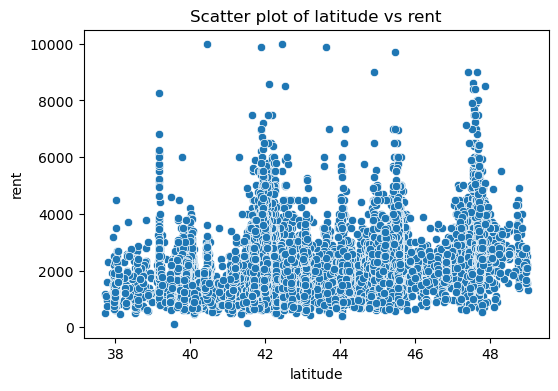

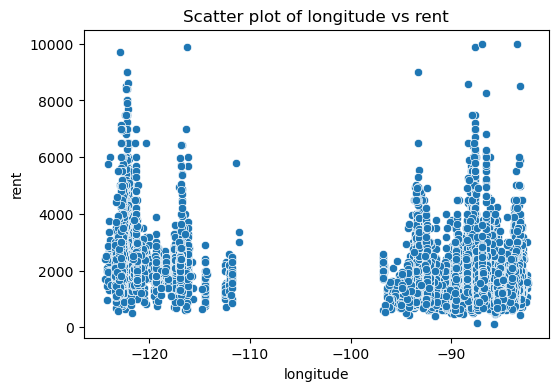

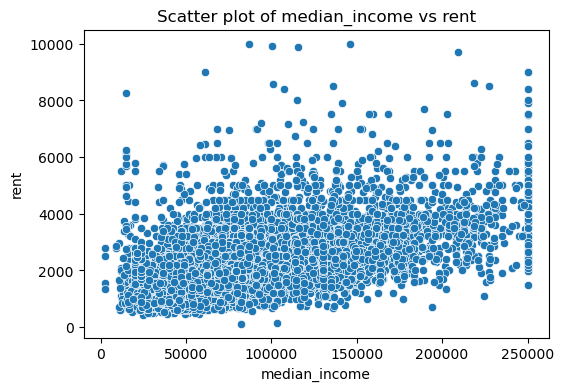

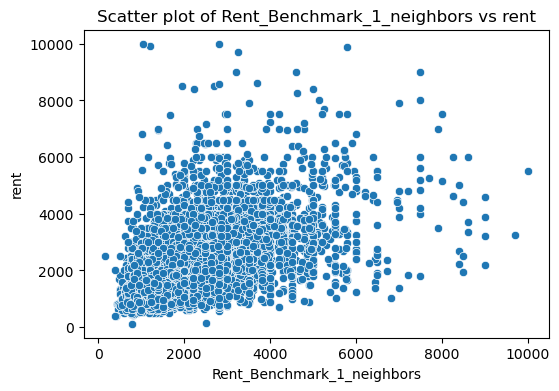

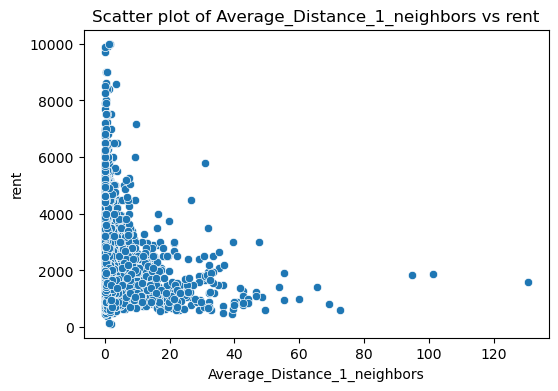

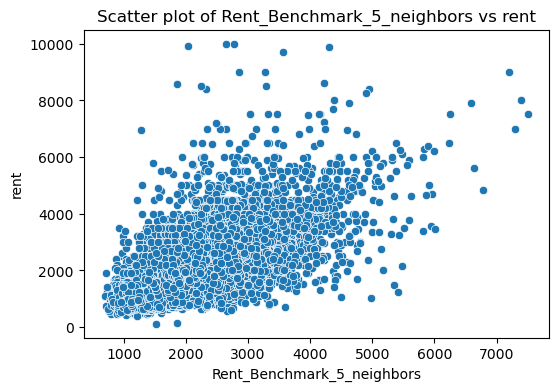

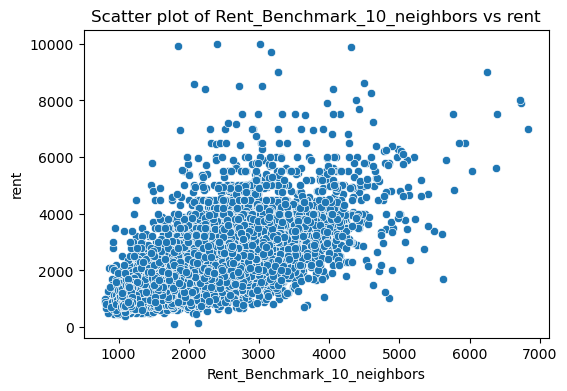

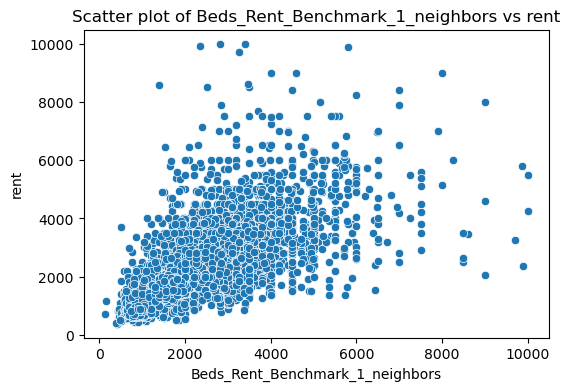

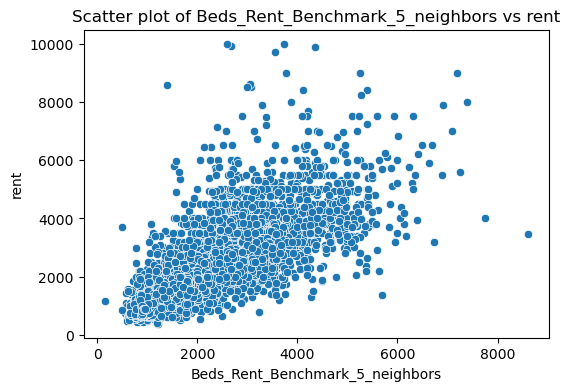

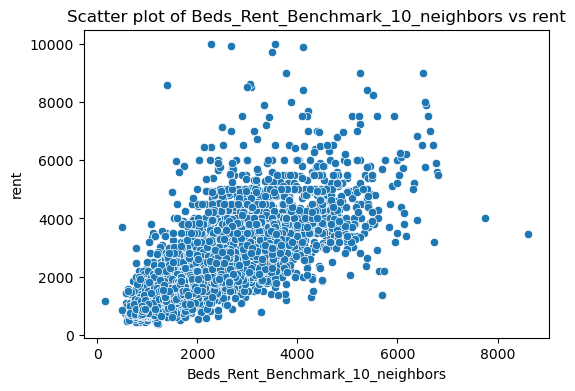

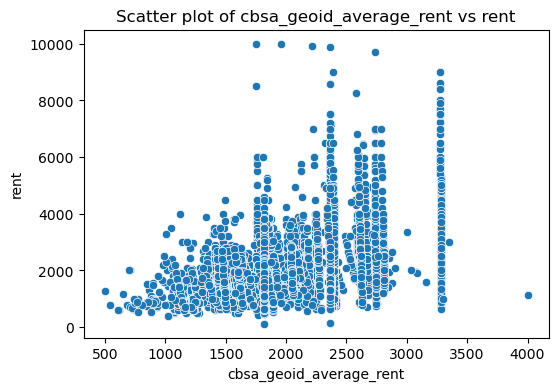

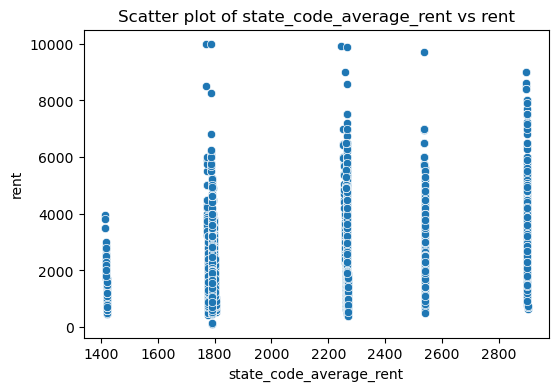

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# List of features to analyze
features = ['square_feet', 'bedrooms', 'bathrooms', #'latitude', 'longitude',
            'median_income', 'Rent_Benchmark_1_neighbors', #'Average_Distance_1_neighbors',
            'Rent_Benchmark_5_neighbors', #'Average_Distance_5_neighbors', 
            'Rent_Benchmark_10_neighbors', #'Average_Distance_10_neighbors',
            'Beds_Rent_Benchmark_1_neighbors', #'Beds_Average_Distance_1_neighbors',
            'Beds_Rent_Benchmark_5_neighbors', #'Beds_Average_Distance_5_neighbors',
            'Beds_Rent_Benchmark_10_neighbors', #'Beds_Average_Distance_10_neighbors',
            'cbsa_geoid_average_rent', 'state_code_average_rent']

target = 'rent'

# 1. Scatter Plots
def plot_scatter_plots(df, features, target):
    for feature in features:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df[feature], y=df[target])
        plt.title(f'Scatter plot of {feature} vs {target}')
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.show()

# Plot all scatter plots
plot_scatter_plots(df, features, target)



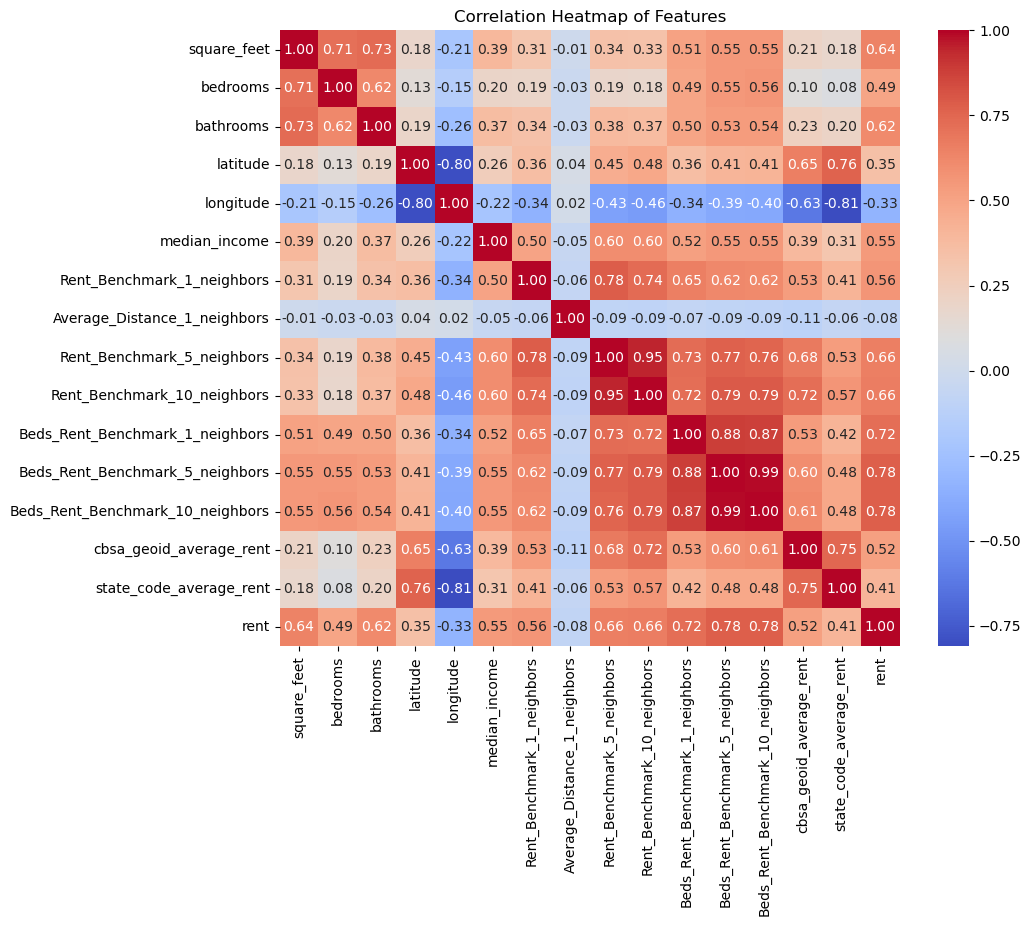

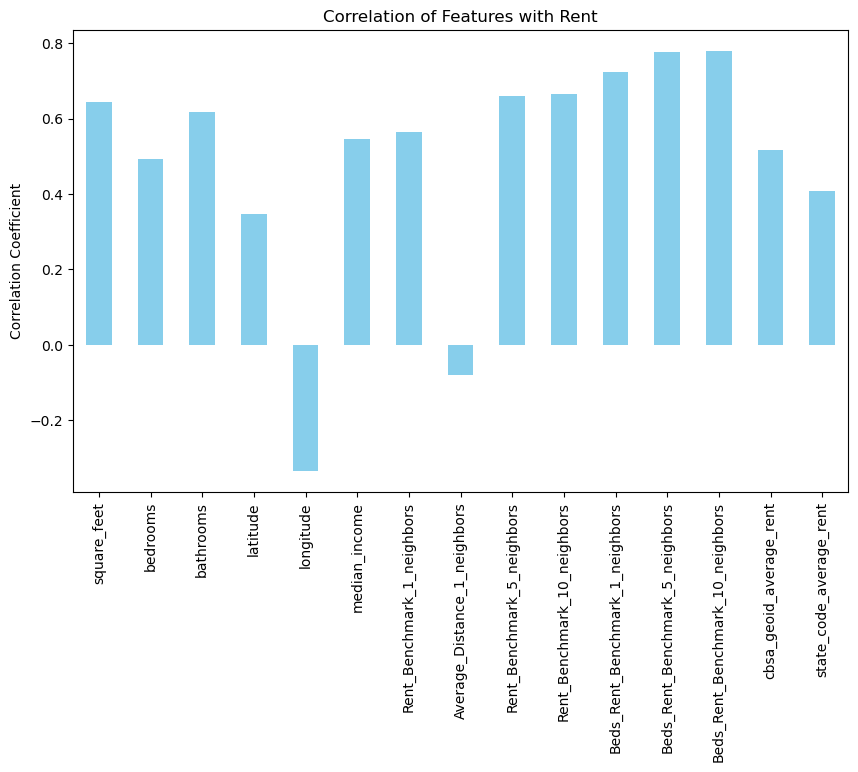

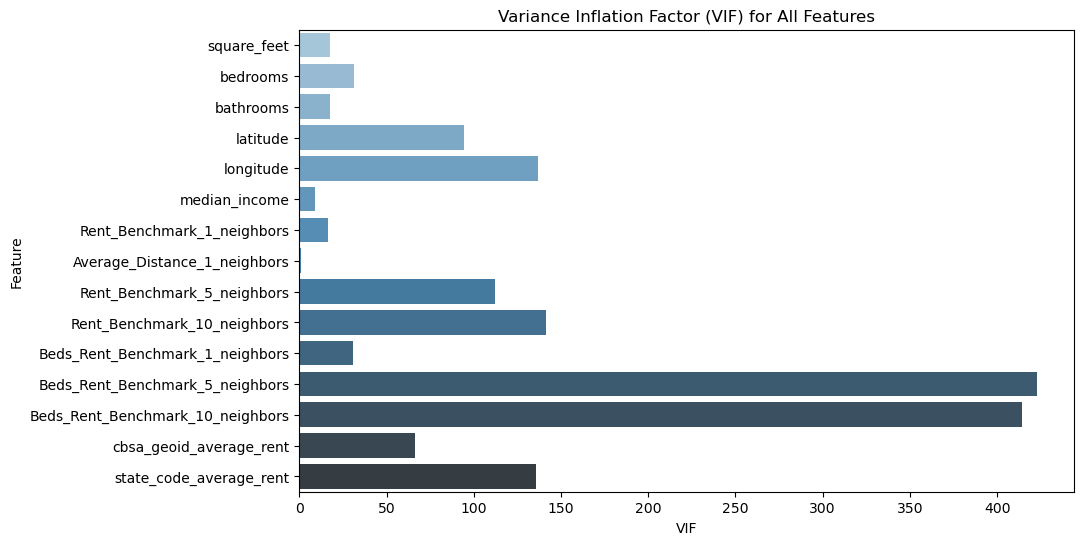

In [47]:

# 2. Correlation Coefficients
correlation_matrix = df[features + [target]].corr()

# Create a heatmap to visualize correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Correlation Heatmap of Features")
plt.show()

# Plot the correlation of each feature with the target (rent)
plt.figure(figsize=(10, 6))
correlation_with_rent = correlation_matrix[target].drop(target)  # Exclude the rent itself
correlation_with_rent.plot(kind='bar', color='skyblue')
plt.title("Correlation of Features with Rent")
plt.ylabel("Correlation Coefficient")
plt.show()

# 3. Multicollinearity (Variance Inflation Factor - VIF)
def calculate_vif(df, features):
    X = df[features].dropna()  # Drop rows with missing values for VIF calculation
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(features))]
    return vif_data

# Calculate VIF for all features
vif = calculate_vif(df, features)

# Plot the VIF values
plt.figure(figsize=(10, 6))
sns.barplot(x="VIF", y="Feature", data=vif, palette="Blues_d")
plt.title("Variance Inflation Factor (VIF) for All Features")
plt.xlabel("VIF")
plt.ylabel("Feature")
plt.show()

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import xgboost as xgb

# List of features to use for prediction
features = ['square_feet', 'bedrooms', 'bathrooms', 'latitude', 'longitude',
            'median_income', 'Rent_Benchmark_1_neighbors', 'Average_Distance_1_neighbors',
            'Rent_Benchmark_5_neighbors', 'Average_Distance_5_neighbors', 
            'Rent_Benchmark_10_neighbors', 'Average_Distance_10_neighbors',
            'Beds_Rent_Benchmark_1_neighbors', 'Beds_Average_Distance_1_neighbors',
            'Beds_Rent_Benchmark_5_neighbors', 'Beds_Average_Distance_5_neighbors',
            'Beds_Rent_Benchmark_10_neighbors', 'Beds_Average_Distance_10_neighbors',
            'cbsa_geoid_average_rent', 'state_code_average_rent']

target = 'rent'

# Drop rows with missing values in any of the features or target
df_clean = df[features + [target]].dropna()

# Split the data into training and testing sets
X = df_clean[features]
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models you want to train and evaluate
models = {
    # 'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Linear Regression': LinearRegression()
}

# Function to train and evaluate the models
def train_and_evaluate_models(models, X_train, X_test, y_train, y_test, add_interactions=False):
    # Loop over the models
    for name, model in models.items():
        # Create a pipeline to scale the data and optionally add interaction terms
        if add_interactions:
            model_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),  # Add interaction terms
                ('model', model)
            ])
            print(f"\nTraining {name} model with interactions...")
        else:
            model_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])
            print(f"\nTraining {name} model without interactions...")

        # Fit the model
        model_pipeline.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model_pipeline.predict(X_test)

        # Evaluate the model
        mse = mean_absolute_error(y_test, y_pred)
        medae = median_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"{name} - Mean Absolute Error: {mse}")
        print(f"median absolute error {medae}")
        print(f"{name} - R-squared: {r2}")

        # Displaying first few actual vs predicted rent values
        predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
        display(predictions.head(10))

# Train and evaluate the models without interactions
train_and_evaluate_models(models, X_train, X_test, y_train, y_test, add_interactions=False)

# Train and evaluate the models with interactions
train_and_evaluate_models(models, X_train, X_test, y_train, y_test, add_interactions=True)



Training XGBoost model without interactions...
XGBoost - Mean Absolute Error: 137.46043408583546
median absolute error 82.55609130859375
XGBoost - R-squared: 0.9298049669640871


,Actual,Predicted
5244,1150.0,1204.787231
5531,3500.0,3267.442139
5456,2445.0,2523.616699
5011,2195.0,2083.882568
4100,900.0,904.559204
7610,3150.0,3122.897705
9401,2995.0,3129.239746
8899,2900.0,3241.720459
35,3645.0,3569.967529
1468,3000.0,3206.269775



Training Ridge Regression model without interactions...
Ridge Regression - Mean Absolute Error: 341.6225531853417
median absolute error 238.3000957153771
Ridge Regression - R-squared: 0.7216954682913318


,Actual,Predicted
5244,1150.0,1383.770897
5531,3500.0,3140.977729
5456,2445.0,2257.239690
5011,2195.0,2138.581433
4100,900.0,1029.659899
7610,3150.0,2509.083047
9401,2995.0,3148.252865
8899,2900.0,1963.385678
35,3645.0,4037.685895
1468,3000.0,3197.618035



Training Lasso Regression model without interactions...
Lasso Regression - Mean Absolute Error: 341.5003708291128
median absolute error 238.7715427923049
Lasso Regression - R-squared: 0.7217310732669944


,Actual,Predicted
5244,1150.0,1383.338521
5531,3500.0,3140.752215
5456,2445.0,2256.423864
5011,2195.0,2138.754249
4100,900.0,1029.679649
7610,3150.0,2508.524022
9401,2995.0,3147.873163
8899,2900.0,1962.971536
35,3645.0,4037.641683
1468,3000.0,3197.269271



Training Linear Regression model without interactions...
Linear Regression - Mean Absolute Error: 341.62737972400555
median absolute error 238.36956194827144
Linear Regression - R-squared: 0.7216963724122996


,Actual,Predicted
5244,1150.0,1383.870078
5531,3500.0,3140.989010
5456,2445.0,2257.194590
5011,2195.0,2138.528313
4100,900.0,1029.616075
7610,3150.0,2509.256199
9401,2995.0,3148.359431
8899,2900.0,1963.477872
35,3645.0,4037.731952
1468,3000.0,3197.703569



Training XGBoost model with interactions...
XGBoost - Mean Absolute Error: 154.22862004490756
median absolute error 92.2166748046875
XGBoost - R-squared: 0.9169555830236278


,Actual,Predicted
5244,1150.0,1134.588135
5531,3500.0,3439.726562
5456,2445.0,2555.165039
5011,2195.0,2149.123291
4100,900.0,846.296387
7610,3150.0,3106.609131
9401,2995.0,2820.909180
8899,2900.0,2064.531982
35,3645.0,3500.983887
1468,3000.0,3053.395996



Training Ridge Regression model with interactions...
Ridge Regression - Mean Absolute Error: 327.01498428484643
median absolute error 221.59110620495198
Ridge Regression - R-squared: 0.7428456058636699


,Actual,Predicted
5244,1150.0,1292.334124
5531,3500.0,3141.382573
5456,2445.0,2326.195763
5011,2195.0,2227.113228
4100,900.0,1162.789065
7610,3150.0,2647.820357
9401,2995.0,3235.998007
8899,2900.0,1725.944332
35,3645.0,4099.085383
1468,3000.0,3183.847086



Training Lasso Regression model with interactions...
Lasso Regression - Mean Absolute Error: 325.93566981799404
median absolute error 220.7104591105574
Lasso Regression - R-squared: 0.7439442271132918


c:\Users\mattl\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.789e+08, tolerance: 8.589e+05
  model = cd_fast.enet_coordinate_descent(


,Actual,Predicted
5244,1150.0,1292.403238
5531,3500.0,3134.889428
5456,2445.0,2328.860968
5011,2195.0,2221.591187
4100,900.0,1160.603147
7610,3150.0,2643.933072
9401,2995.0,3231.066886
8899,2900.0,1705.006575
35,3645.0,4097.622469
1468,3000.0,3175.550785



Training Linear Regression model with interactions...
Linear Regression - Mean Absolute Error: 327.1767280302065
median absolute error 221.26209021421528
Linear Regression - R-squared: 0.7425774418842865


,Actual,Predicted
5244,1150.0,1291.902139
5531,3500.0,3143.654080
5456,2445.0,2328.330627
5011,2195.0,2227.569588
4100,900.0,1162.688583
7610,3150.0,2646.872928
9401,2995.0,3235.768689
8899,2900.0,1729.428019
35,3645.0,4095.317719
1468,3000.0,3185.651474


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Mean Squared Error: 51631.22761974078
R-squared: 0.9491823392312185


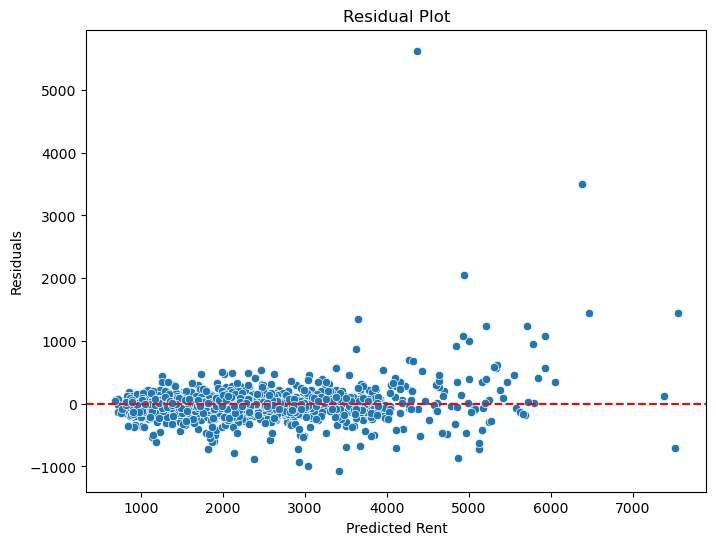

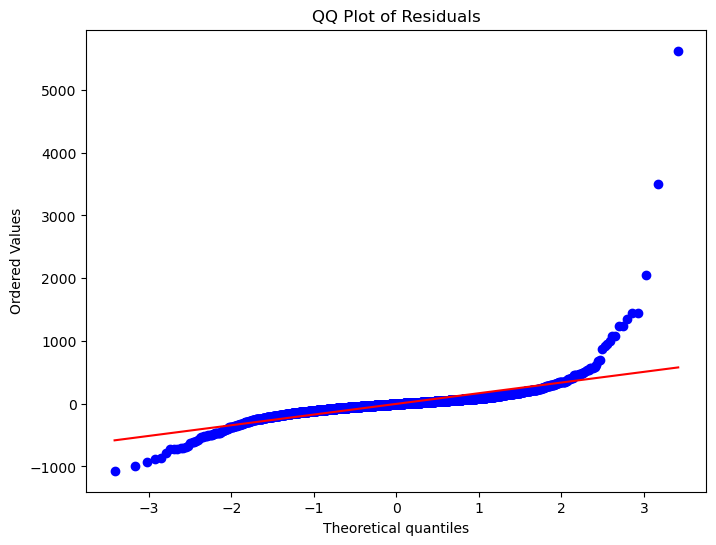

Cross-validated RMSE: 261.0288297432718 ± 59.05523586321781


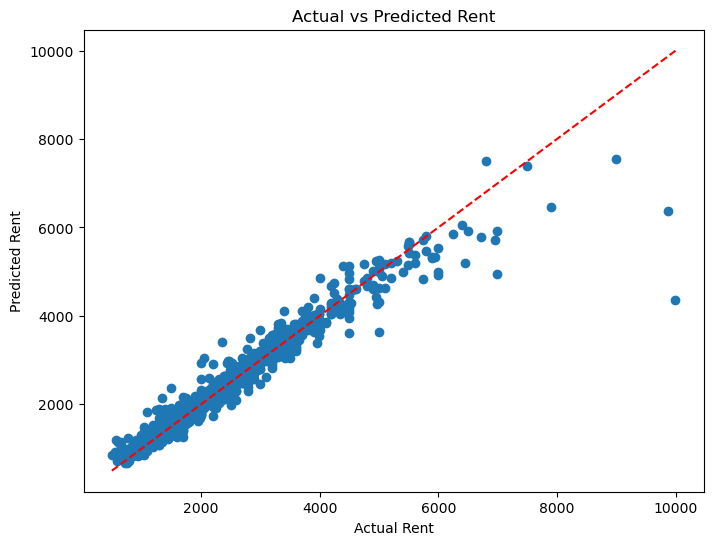

In [54]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd

# List of features to use for prediction
features = ['square_feet', 'bedrooms', 'bathrooms', 'latitude', 'longitude',
            'median_income', 'Rent_Benchmark_1_neighbors', 'Average_Distance_1_neighbors',
            'Rent_Benchmark_5_neighbors', 'Average_Distance_5_neighbors', 
            'Rent_Benchmark_10_neighbors', 'Average_Distance_10_neighbors',
            'Beds_Rent_Benchmark_1_neighbors', 'Beds_Average_Distance_1_neighbors',
            'Beds_Rent_Benchmark_5_neighbors', 'Beds_Average_Distance_5_neighbors',
            'Beds_Rent_Benchmark_10_neighbors', 'Beds_Average_Distance_10_neighbors',
            'cbsa_geoid_average_rent', 'state_code_average_rent']

target = 'rent'

# Drop rows with missing values in any of the features or target
df_clean = df[features + [target]].dropna()

# Split the data into training and testing sets
X = df_clean[features]
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. XGBoost Model with Cross-validation and Hyperparameter Tuning
# Define the XGBoost model
xgboost_model = xgb.XGBRegressor(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model from GridSearchCV
best_xgb_model = grid_search.best_estimator_

# 2. Evaluate the model on the test set
y_pred = best_xgb_model.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# 3. Plot Residuals
residuals = y_test - y_pred

# Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Rent")
plt.ylabel("Residuals")
plt.show()

# 4. QQ Plot (to check for normality of residuals)
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

# 5. Cross-Validation Score
cv_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-validated RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}")

# 6. Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs Predicted Rent")
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.show()


In [56]:
print(mean_absolute_error(y_test, y_pred))

print(median_absolute_error(y_test, y_pred))


107.96324852821917
61.1954345703125


In [67]:
# Rejoin predictions to the original test set
X_test_with_index = X_test.copy()
X_test_with_index['Actual_Rent'] = y_test
X_test_with_index['Predicted_Rent'] = y_pred
X_test_with_index['Error'] = X_test_with_index['Actual_Rent'] - X_test_with_index['Predicted_Rent']

# Rejoin the state_code to the test set from the original df
X_test_with_state = X_test_with_index.merge(df[['state_code']], left_index=True, right_index=True)


# Calculate the error by state
error_by_state = X_test_with_state.groupby('state_code').agg(
    Mean_Absolute_Error=('Error', 'mean'),
    Mean_Absolute_Percentage_Error=('Error', lambda x: np.mean(np.abs(x / X_test_with_state['Actual_Rent']) * 100)),
    RMSE=('Error', lambda x: np.sqrt(np.mean(x**2)))
).reset_index()


# Display the error by state
print("Error by state:")
display(error_by_state)

error_by_br= X_test_with_state.groupby('bedrooms').agg(
    Mean_Absolute_Error=('Error', 'mean'),
    Mean_Absolute_Percentage_Error=('Error', lambda x: np.mean(np.abs(x / X_test_with_state['Actual_Rent']) * 100)),
    RMSE=('Error', lambda x: np.sqrt(np.mean(x**2)))
).reset_index()

# Display the error by state
print("Error by bed:")
display(error_by_br)

error_by_br= X_test_with_state.groupby('bathrooms').agg(
    Mean_Absolute_Error=('Error', 'mean'),
    Mean_Absolute_Percentage_Error=('Error', lambda x: np.mean(np.abs(x / X_test_with_state['Actual_Rent']) * 100)),
    RMSE=('Error', lambda x: np.sqrt(np.mean(x**2)))
).reset_index()

# Display the error by state
print("Error by bath:")
display(error_by_br)




Error by state:


,state_code,Mean_Absolute_Error,Mean_Absolute_Percentage_Error,RMSE
0,IA,-65.289334,10.012980,234.042328
1,ID,-41.804011,9.673772,264.756926
2,IL,13.873988,3.844195,201.165033
3,IN,-22.301667,5.417229,153.829894
4,MI,14.435477,5.330139,394.905999
5,MN,-17.483179,6.334958,194.679534
6,OR,-7.725022,4.552826,220.928226
7,WA,14.806685,3.526269,175.682449
8,WI,-52.711787,12.236492,237.634308


Error by bed:


,bedrooms,Mean_Absolute_Error,Mean_Absolute_Percentage_Error,RMSE
0,1.0,-5.957422,7.922854,141.602889
1,2.0,-4.227823,6.221269,215.713717
2,3.0,-6.784277,4.163416,156.416648
3,4.0,11.546241,4.826426,376.484566
4,5.0,-17.991076,4.482281,214.753588


Error by bath:


,bathrooms,Mean_Absolute_Error,Mean_Absolute_Percentage_Error,RMSE
0,1.0,-14.151913,6.360655,132.982033
1,1.5,20.187226,4.910129,164.047026
2,2.0,-9.657181,4.637514,172.511508
3,2.5,1.577486,3.498649,261.799536
4,3.0,-22.438328,4.079587,191.378244
5,3.5,211.533445,7.432347,905.782985


In [66]:
display(X_test_with_state)

,square_feet,bedrooms,bathrooms,latitude,longitude,median_income,Rent_Benchmark_1_neighbors,Average_Distance_1_neighbors,Rent_Benchmark_5_neighbors,Average_Distance_5_neighbors,...,Beds_Rent_Benchmark_5_neighbors,Beds_Average_Distance_5_neighbors,Beds_Rent_Benchmark_10_neighbors,Beds_Average_Distance_10_neighbors,cbsa_geoid_average_rent,state_code_average_rent,Actual_Rent,Predicted_Rent,Error,state_code
5244,650.0,1.0,1.0,42.967060,-85.652824,71979.0,1700.0,0.301277,1859.0,0.588538,...,1350.0,1.395047,1350.000000,1.395047,2019.064516,1776.360119,1150.0,1277.357544,-127.357544,MI
5531,1500.0,3.0,1.5,42.176238,-87.826710,141131.0,3600.0,1.495599,2995.0,1.757428,...,3689.0,1.972688,3659.500000,2.419273,2363.836590,2266.312439,3500.0,3431.384277,68.615723,IL
5456,1098.0,2.0,2.0,42.202231,-88.261430,103971.0,2500.0,1.288101,2359.0,1.465630,...,2175.0,2.553590,2103.125000,3.558209,2364.211368,2266.653312,2445.0,2480.908203,-35.908203,IL
5011,1830.0,4.0,2.0,42.212746,-85.532857,123693.0,850.0,3.485327,1639.0,3.829312,...,2108.0,5.649896,2089.166667,6.063081,1792.232143,1775.582589,2195.0,2257.584229,-62.584229,MI
4100,600.0,2.0,1.0,42.476819,-82.950890,47723.0,1500.0,0.975536,1350.0,1.087121,...,1062.5,1.424369,1062.500000,1.424369,1764.383202,1776.546131,900.0,909.026917,-9.026917,MI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4081,1462.0,3.0,1.5,42.479515,-83.022510,52087.0,1500.0,0.758032,1399.0,1.298617,...,1565.0,1.473102,1463.500000,1.995166,1763.727034,1776.174107,1400.0,1385.906982,14.093018,MI
11066,1604.0,3.0,2.0,39.686586,-86.076769,53029.0,1795.0,0.416100,1641.0,0.712860,...,1525.0,0.874101,1906.300000,1.371135,1815.695167,1790.835395,1685.0,1718.894287,-33.894287,IN
9587,1175.0,4.0,2.0,44.704971,-93.438428,80789.0,2195.0,1.248503,2386.8,2.135907,...,2935.0,7.712951,2740.900000,10.073992,2396.659810,2267.080664,2195.0,2068.396240,126.603760,MN
8577,750.0,2.0,1.0,41.583330,-93.714795,42869.0,2400.0,1.607371,1812.0,2.491247,...,1118.0,4.322843,1118.000000,4.322843,1644.252174,1421.948925,775.0,910.814575,-135.814575,IA


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 600, 'subsample': 0.85}
Validation Mean Squared Error: 117193.2611956239
Validation R-squared: 0.8969690785306303
Validation Mean Absolute Error: 133.60142130813512
Test Mean Squared Error: 65106.94918853991
Test R-squared: 0.935918958156081
Test Mean Absolute Error: 116.95795681933325


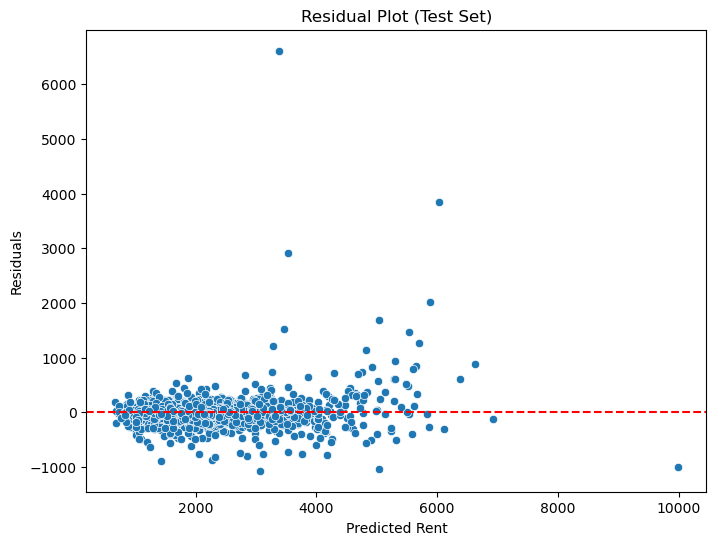

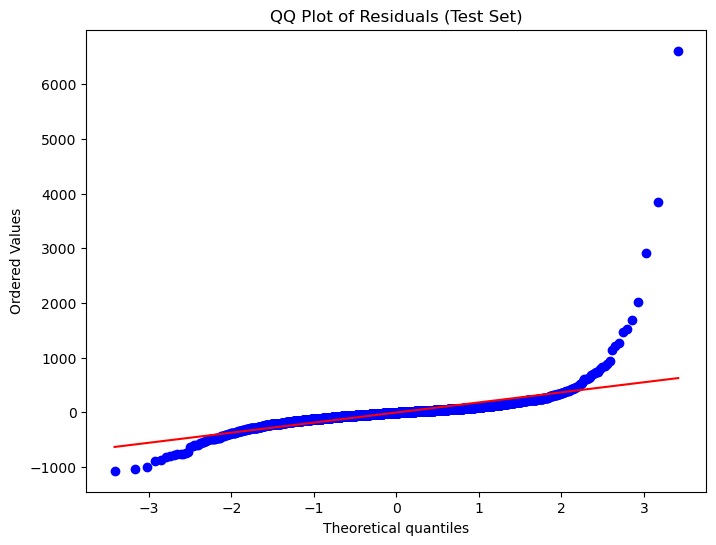

Cross-validated RMSE: 249.68744197313026 ± 32.91928820648822


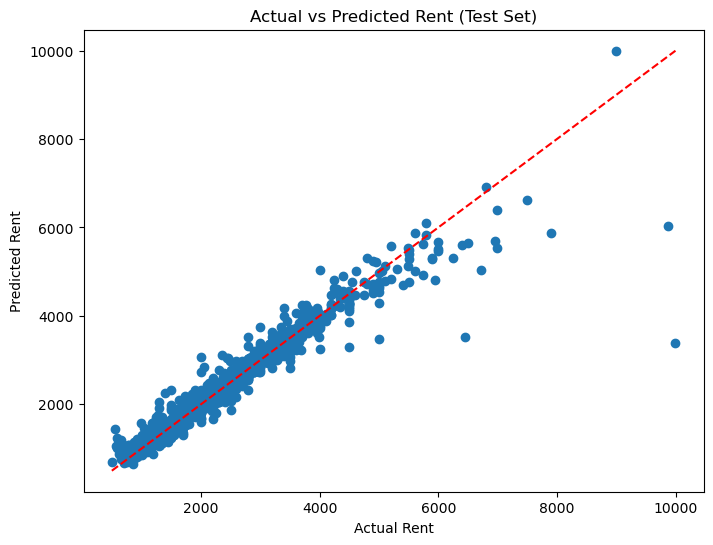

Error by state:


,state_code,Mean_Absolute_Error,Mean_Absolute_Percentage_Error,RMSE
0,IA,140.313921,9.372240,207.832241
1,ID,195.185539,10.153288,389.540953
2,IL,92.116269,4.136717,223.420978
3,IN,104.464979,6.129045,169.552232
4,MI,115.310404,5.610410,453.601283
5,MN,124.306950,5.966838,202.217432
6,OR,129.690467,4.926154,198.596912
7,WA,114.741143,3.748433,200.540221
8,WI,213.737429,16.627357,308.049228


,Actual_Rent,Predicted_Rent,Error,state_code
5244,1150.0,1168.770874,-18.770874,MI
5531,3500.0,3452.333496,47.666504,IL
5456,2445.0,2464.228271,-19.228271,IL
5011,2195.0,2215.451904,-20.451904,MI
4100,900.0,948.289612,-48.289612,MI
7610,3150.0,3165.795898,-15.795898,IL
9401,2995.0,3085.080566,-90.080566,MN
8899,2900.0,3019.691650,-119.691650,WI
35,3645.0,3830.251465,-185.251465,WA
1468,3000.0,2977.341553,22.658447,WA


In [69]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd

# List of features to use for prediction
features = ['square_feet', 'bedrooms', 'bathrooms', 'latitude', 'longitude',
            'median_income', 'Rent_Benchmark_1_neighbors', 'Average_Distance_1_neighbors',
            'Rent_Benchmark_5_neighbors', 'Average_Distance_5_neighbors', 
            'Rent_Benchmark_10_neighbors', 'Average_Distance_10_neighbors',
            'Beds_Rent_Benchmark_1_neighbors', 'Beds_Average_Distance_1_neighbors',
            'Beds_Rent_Benchmark_5_neighbors', 'Beds_Average_Distance_5_neighbors',
            'Beds_Rent_Benchmark_10_neighbors', 'Beds_Average_Distance_10_neighbors',
            'cbsa_geoid_average_rent', 'state_code_average_rent']

target = 'rent'

# Drop rows with missing values in any of the features or target
df_clean = df[features + [target, 'state_code']].dropna()

# Split the data into training, validation, and testing sets
X = df_clean[features]
y = df_clean[target]
state_codes = df_clean['state_code']

# First, split X and y into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now split the state_codes based on the same indices used in the split above
_, state_test = train_test_split(state_codes, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# 1. XGBoost Model with Cross-validation and Hyperparameter Tuning
# Define the XGBoost model
xgboost_model = xgb.XGBRegressor(random_state=42)

# Narrowed hyperparameter tuning using GridSearchCV based on previous results
param_grid = {
    'learning_rate': [0.08, 0.1, 0.12],
    'max_depth': [4, 5, 6],
    'n_estimators': [400, 500, 600],
    'subsample': [0.75, 0.8, 0.85],
    'colsample_bytree': [0.9, 1.0]
}

grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the model using GridSearchCV on training set
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model from GridSearchCV
best_xgb_model = grid_search.best_estimator_

# 2. Evaluate the model on the validation set
y_val_pred = best_xgb_model.predict(X_val)

# Evaluation Metrics
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

print(f"Validation Mean Squared Error: {val_mse}")
print(f"Validation R-squared: {val_r2}")
print(f"Validation Mean Absolute Error: {val_mae}")

# 3. Evaluate the model on the test set
y_pred = best_xgb_model.predict(X_test)

# Evaluation Metrics for test set
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print(f"Test Mean Squared Error: {test_mse}")
print(f"Test R-squared: {test_r2}")
print(f"Test Mean Absolute Error: {test_mae}")

# 4. Plot Residuals for test set
residuals = y_test - y_pred

# Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot (Test Set)")
plt.xlabel("Predicted Rent")
plt.ylabel("Residuals")
plt.show()

# 5. QQ Plot (to check for normality of residuals)
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (Test Set)")
plt.show()

# 6. Cross-Validation Score on training set
cv_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-validated RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}")

# 7. Actual vs Predicted Plot (Test Set)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs Predicted Rent (Test Set)")
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.show()

# 8. Rejoin Predictions to the original test set for error analysis by state
X_test_with_index = X_test.copy()
X_test_with_index['Actual_Rent'] = y_test
X_test_with_index['Predicted_Rent'] = y_pred
X_test_with_index['Error'] = X_test_with_index['Actual_Rent'] - X_test_with_index['Predicted_Rent']
X_test_with_index['Absolute_Error'] = np.abs(X_test_with_index['Error'])

# Rejoin the state_code to the test set from the original df
X_test_with_state = X_test_with_index.copy()
X_test_with_state['state_code'] = state_test

# Calculate the error by state
error_by_state = X_test_with_state.groupby('state_code').agg(
    Mean_Absolute_Error=('Absolute_Error', 'mean'),
    Mean_Absolute_Percentage_Error=('Error', lambda x: np.mean(np.abs(x / X_test_with_state['Actual_Rent']) * 100)),
    RMSE=('Error', lambda x: np.sqrt(np.mean(x**2)))
).reset_index()

# Display the error by state
print("Error by state:")
display(error_by_state)

# Display a sample of the test set with actual, predicted rent, and error
display(X_test_with_state[['Actual_Rent', 'Predicted_Rent', 'Error', 'state_code']].head(10))


In [70]:
display(X_test_with_state)

,square_feet,bedrooms,bathrooms,latitude,longitude,median_income,Rent_Benchmark_1_neighbors,Average_Distance_1_neighbors,Rent_Benchmark_5_neighbors,Average_Distance_5_neighbors,...,Beds_Average_Distance_5_neighbors,Beds_Rent_Benchmark_10_neighbors,Beds_Average_Distance_10_neighbors,cbsa_geoid_average_rent,state_code_average_rent,Actual_Rent,Predicted_Rent,Error,Absolute_Error,state_code
5244,650.0,1.0,1.0,42.967060,-85.652824,71979.0,1700.0,0.301277,1859.0,0.588538,...,1.395047,1350.000000,1.395047,2019.064516,1776.360119,1150.0,1168.770874,-18.770874,18.770874,MI
5531,1500.0,3.0,1.5,42.176238,-87.826710,141131.0,3600.0,1.495599,2995.0,1.757428,...,1.972688,3659.500000,2.419273,2363.836590,2266.312439,3500.0,3452.333496,47.666504,47.666504,IL
5456,1098.0,2.0,2.0,42.202231,-88.261430,103971.0,2500.0,1.288101,2359.0,1.465630,...,2.553590,2103.125000,3.558209,2364.211368,2266.653312,2445.0,2464.228271,-19.228271,19.228271,IL
5011,1830.0,4.0,2.0,42.212746,-85.532857,123693.0,850.0,3.485327,1639.0,3.829312,...,5.649896,2089.166667,6.063081,1792.232143,1775.582589,2195.0,2215.451904,-20.451904,20.451904,MI
4100,600.0,2.0,1.0,42.476819,-82.950890,47723.0,1500.0,0.975536,1350.0,1.087121,...,1.424369,1062.500000,1.424369,1764.383202,1776.546131,900.0,948.289612,-48.289612,48.289612,MI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4081,1462.0,3.0,1.5,42.479515,-83.022510,52087.0,1500.0,0.758032,1399.0,1.298617,...,1.473102,1463.500000,1.995166,1763.727034,1776.174107,1400.0,1431.369385,-31.369385,31.369385,MI
11066,1604.0,3.0,2.0,39.686586,-86.076769,53029.0,1795.0,0.416100,1641.0,0.712860,...,0.874101,1906.300000,1.371135,1815.695167,1790.835395,1685.0,1814.714844,-129.714844,129.714844,IN
9587,1175.0,4.0,2.0,44.704971,-93.438428,80789.0,2195.0,1.248503,2386.8,2.135907,...,7.712951,2740.900000,10.073992,2396.659810,2267.080664,2195.0,2092.407959,102.592041,102.592041,MN
8577,750.0,2.0,1.0,41.583330,-93.714795,42869.0,2400.0,1.607371,1812.0,2.491247,...,4.322843,1118.000000,4.322843,1644.252174,1421.948925,775.0,828.585388,-53.585388,53.585388,IA


In [77]:
# Train the final model on the full dataset (X, y)
final_xgb_model = xgb.XGBRegressor(**grid_search.best_params_, random_state=42)
final_xgb_model.fit(X, y)

# Predict on the full dataset
full_dataset_predictions = final_xgb_model.predict(X)

# Evaluate the model on the full dataset
full_mse = mean_squared_error(y, full_dataset_predictions)
full_r2 = r2_score(y, full_dataset_predictions)
full_mae = mean_absolute_error(y, full_dataset_predictions)

print(f"Full Dataset Mean Squared Error: {full_mse}")
print(f"Full Dataset R-squared: {full_r2}")
print(f"Full Dataset Mean Absolute Error: {full_mae}")

# Rejoin predictions to the original full dataset
df_clean['Predicted_Rent'] = full_dataset_predictions
df_clean['Error'] = df_clean[target] - df_clean['Predicted_Rent']
df_clean['Absolute_Error'] = np.abs(df_clean['Error'])

# Error by state for the full dataset
error_by_state_full = df_clean.groupby('state_code').agg(
    Mean_Absolute_Error=('Absolute_Error', 'mean'),
    Mean_Absolute_Percentage_Error=('Error', lambda x: np.mean(np.abs(x / df_clean['rent']) * 100)),
    RMSE=('Error', lambda x: np.sqrt(np.mean(x**2))),
    count=('Error', 'count')
).reset_index()

# Display the error by state for the full dataset
print("Error by state for the full dataset:")
display(error_by_state_full)

# Display a sample of the full dataset with actual, predicted rent, and error
# display(df_clean[['rent', 'Predicted_Rent', 'Error','state_code']].head(10))


Full Dataset Mean Squared Error: 6651.802892175793
Full Dataset R-squared: 0.9932848213133543
Full Dataset Mean Absolute Error: 57.46087846783082
Error by state for the full dataset:


,state_code,Mean_Absolute_Error,Mean_Absolute_Percentage_Error,RMSE,count
0,IA,56.075617,4.440346,69.824415,323
1,ID,88.751194,4.187744,129.480607,466
2,IL,50.249350,2.437854,71.015344,2795
3,IN,50.389188,3.061401,73.674793,1711
4,MI,51.748448,3.141705,71.098013,1167
5,MN,72.419702,3.572799,93.782785,770
6,OR,63.671712,2.665294,86.868371,1383
7,WA,51.877886,1.845066,71.612673,1946
8,WI,102.130623,6.610575,138.824033,348
